# Загружаем необходимые библиотеки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import chi2_contingency, chi2, norm
import requests
from urllib.parse import urlencode

# Загрузим датасет с результатами А/В-теста

In [2]:
# Функция для выгрузки данных через API
def url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key))
    response_active = requests.get(final_url)
    download_url = response_active.json()['href']
    return download_url


In [3]:
Download_URL_Dataset = url('https://disk.yandex.ru/d/SOkIsD5A8xlI7Q')
DF = pd.read_csv(Download_URL_Dataset, sep=';')
DF.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


# Проверим датасет на наличие пропусков и оценим его размер

In [4]:
print(
    'Размер массива -', DF.shape, '\n', '-----------------------------------------------------------------',
    '\nПроверка пропусков (пропусков нет) - \n', DF.isna().sum(), '\n', '-----------------------------------------------------------------')

Размер массива - (404770, 3) 
 ----------------------------------------------------------------- 
Проверка пропусков (пропусков нет) - 
 user_id      0
revenue      0
testgroup    0
dtype: int64 
 -----------------------------------------------------------------


# Анализ данных

### Определим и проанализируем следующие показатели по двум группам А и В:
   - Количество человек;
   - Количество заплативших клиентов;
   - Средний чек;
   - Медианный чек;
   - Суммарная выручка;
   - ARPPU;
   - ARPU;
   - CR;

In [5]:
# Определим количество человек по группам:
Indicators = DF.groupby('testgroup')['user_id'].count().to_frame('Number of Users').reset_index()
Indicators

,testgroup,Number of Users
0,a,202103
1,b,202667


In [6]:
# Узнаем количество активных пользователей, кто совершал оплату - клиентов:
Active_A = len(DF['user_id'].loc[(DF['revenue']>0) & (DF['testgroup']=='a')])
Active_B = len(DF['user_id'].loc[(DF['revenue']>0) & (DF['testgroup']=='b')])
Indicators['Active_Users'] = [Active_A, Active_B]
Indicators

,testgroup,Number of Users,Active_Users
0,a,202103,1928
1,b,202667,1805


In [7]:
# Далее вычислим суммарную и максимальную выручку по группам и добавим их в датафрейм с показателями.
Indicators['Total revenue'] = DF.groupby('testgroup', as_index=False).agg({'revenue': 'sum'}).round(2)['revenue']
Indicators

,testgroup,Number of Users,Active_Users,Total revenue
0,a,202103,1928,5136189
1,b,202667,1805,5421603


In [8]:
# Средний чек:
Avg_Check_A = DF['revenue'].loc[(DF['testgroup']=='a') & (DF['revenue']>0)].mean().round(2)
Avg_Check_B = DF['revenue'].loc[(DF['testgroup']=='b') & (DF['revenue']>0)].mean().round(2)
Indicators['Avg_Check'] = [Avg_Check_A, Avg_Check_B]
Indicators

,testgroup,Number of Users,Active_Users,Total revenue,Avg_Check
0,a,202103,1928,5136189,2664.00
1,b,202667,1805,5421603,3003.66


In [9]:
# Медианный чек:
Median_Check_A = DF['revenue'].loc[(DF['revenue']>0) & (DF['testgroup']=='a')].median()
Median_Check_B = DF['revenue'].loc[(DF['revenue']>0) & (DF['testgroup']=='b')].median()
Indicators['Median_Check'] = [Median_Check_A, Median_Check_B]
Indicators

,testgroup,Number of Users,Active_Users,Total revenue,Avg_Check,Median_Check
0,a,202103,1928,5136189,2664.00,311.0
1,b,202667,1805,5421603,3003.66,3022.0


In [10]:
# Далее определим конверсию пользователей в клиентов (кто заплатил):
Indicators['Conversion'] = (Indicators['Active_Users'] / Indicators['Number of Users']) * 100
Indicators

,testgroup,Number of Users,Active_Users,Total revenue,Avg_Check,Median_Check,Conversion
0,a,202103,1928,5136189,2664.00,311.0,0.953969
1,b,202667,1805,5421603,3003.66,3022.0,0.890624


In [11]:
# Рассчитаем ARPPU - средний доход на платящего пользователя:
ARPPU_A = DF['revenue'].loc[(DF['revenue']>0) & (DF['testgroup']=='a')].sum() / DF['revenue'].loc[(DF['revenue']>0) & (DF['testgroup']=='a')].count()
ARPPU_B = DF['revenue'].loc[(DF['revenue']>0) & (DF['testgroup']=='b')].sum() / DF['revenue'].loc[(DF['revenue']>0) & (DF['testgroup']=='b')].count()
Indicators['ARPPU'] = [ARPPU_A, ARPPU_B]
Indicators

,testgroup,Number of Users,Active_Users,Total revenue,Avg_Check,Median_Check,Conversion,ARPPU
0,a,202103,1928,5136189,2664.00,311.0,0.953969,2663.998444
1,b,202667,1805,5421603,3003.66,3022.0,0.890624,3003.658172


In [12]:
# Рассчитаем ARPU - средний доход на пользователя:
Indicators['ARPU'] = Indicators['ARPPU'] * (Indicators['Conversion'] / 100)
Indicators

,testgroup,Number of Users,Active_Users,Total revenue,Avg_Check,Median_Check,Conversion,ARPPU,ARPU
0,a,202103,1928,5136189,2664.00,311.0,0.953969,2663.998444,25.413720
1,b,202667,1805,5421603,3003.66,3022.0,0.890624,3003.658172,26.751287


### Выводы

- Количество активных пользователей в группе В меньше чем в А, однако остальные метрики, кроме конверсии, превосходят группу А.
- Наблюдается сильная разница в медианах, но в средних это расхождение существенно меньше.

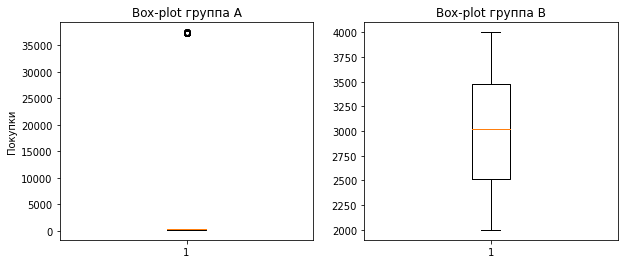

In [13]:
# Построим графики boxplot, для того, чтобы сравнить две выборки между собой и проверить их на наличие выбросов.

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

data_A = DF['revenue'].loc[(DF['testgroup']=='a') & (DF['revenue']>0)]
data_B = DF['revenue'].loc[(DF['testgroup']=='b') & (DF['revenue']>0)]

axs[0].set(ylabel='Покупки')
axs[0].boxplot(data_A)
axs[0].set_title('Box-plot группа А')

axs[1].boxplot(data_B)
axs[1].set_title('Box-plot группа B');

- В группе А видны сильные отклонения от медианного значения.
- У группы В выбросов нет и демонстрируется распределение стоимостей покупок от 2000 до 4000 рублей.

In [14]:
# Посмотрим, как много человек из группы А сделало покупку стоимостью более чем на 5000 рублей.
Num_Jump = DF['revenue'].loc[(DF['testgroup']=='a') & (DF['revenue']>5000)]
print('Количество людей: ', len(Num_Jump))
print('Средний чек: ', Num_Jump.mean().round(2))
print('Медианный чек: ', Num_Jump.median())

Количество людей:  123
Средний чек:  37319.12
Медианный чек:  37311.0


### Анализ конверсии

In [15]:
# Конверсия в группе В немного ниже чем в А. Увеличение конверсии существенно увеличит общую выручку.
Indicators[['testgroup', 'Conversion']]

,testgroup,Conversion
0,a,0.953969
1,b,0.890624


#### Проведем анализ конверсии.
#### Его можно провести при помощи критерия Хи-Квадрат.
Критерий Хи-квадрат является статистическим методом, который позволяет определить, являются ли различия между наблюдаемыми и ожидаемыми частотами в таблице сопряженности статистически значимыми.\
Проведем анализ, чтобы определить, существуют ли различия между двумя группами в том, были ли оплаты совершены или нет.  Т.к. наши переменные являются категориальными (группы "А" и "В" и наличие оплаты "есть оплата" и "нет оплаты"), используем критерий Хи-квадрат и создадим таблицу сопряженности для анализа.

In [16]:
# Для этого создадим новый столбец с данными: совершил оплату и не совершил.
Pay = []
for i in range(0, DF.shape[0]):
    if DF['revenue'][i] == 0:
        Pay.append('no')
    elif DF['revenue'][i] != 0:
        Pay.append('yes')
DF['Pay'] = Pay

In [17]:
# Cоздадим таблицу сопряженности по группам и наличию оплаты:
table = DF.groupby(['testgroup', 'Pay']).agg({'Pay': 'count'}).rename(columns={'Pay': 'count'}).reset_index()
table

,testgroup,Pay,count
0,a,no,200175
1,a,yes,1928
2,b,no,200862
3,b,yes,1805


In [18]:
# Итоговая таблица сопряжённости
table = table.pivot(index='testgroup', columns='Pay', values='count')
table

Pay,no,yes
testgroup,,
a,200175,1928
b,200862,1805


In [19]:
# Применяем критерий Хи-квадрат к полученной таблице
stat, p, dof, expected = chi2_contingency(table)
print(f"Хи-квадрат: {stat}\np-value: {p}\nКоличество степеней свободы: {dof}")

Хи-квадрат: 4.374729521260405
p-value: 0.03647561892312613
Количество степеней свободы: 1


#### Проводим проверку гипотезы с использованием полученных результатов:
- H0 (нулевая гипотеза): Связь между конверсией и групповой принадлежностью отсутствует;
- H1 (альтернативная гипотеза): Взаимосвязь между группой и конверсией, все-таки, имеется.

In [20]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0, Хи-квадрат =', abs(stat), '\n', \
           'Можно сказать, что набор акционных предложений для группы B оказал влияние на желание пользователей совершать покупки.')
else:
    print('Не отклоняем H0, Хи-квадрат =', abs(stat))

Отклоняем H0, Хи-квадрат = 4.374729521260405 
 Можно сказать, что набор акционных предложений для группы B оказал влияние на желание пользователей совершать покупки.


#### Проведем анализ конверсии с отсеченными выбросами

In [21]:
df_clean = DF.loc[DF['revenue'] < 5000]
df_clean

,user_id,revenue,testgroup,Pay
0,1,0,b,no
1,2,0,a,no
2,3,0,a,no
3,4,0,b,no
4,5,0,b,no
...,...,...,...,...
404765,404766,0,a,no
404766,404767,0,b,no
404767,404768,231,a,yes
404768,404769,0,a,no


In [22]:
table_clean = df_clean.groupby(['testgroup', 'Pay']).agg({'Pay': 'count'}).rename(columns={'Pay': 'count'}).reset_index()
table_clean

,testgroup,Pay,count
0,a,no,200175
1,a,yes,1805
2,b,no,200862
3,b,yes,1805


In [23]:
table_clean = table_clean.pivot(index='testgroup', columns='Pay', values='count')
table_clean

Pay,no,yes
testgroup,,
a,200175,1805
b,200862,1805


In [24]:
stat, p, dof, expected = chi2_contingency(table_clean)
print(f"Хи-квадрат: {stat}\np-value: {p}\nКоличество степеней свободы: {dof}")

Хи-квадрат: 0.0073526946879701
p-value: 0.9316668591658103
Количество степеней свободы: 1


#### Проводим проверку гипотезы с использованием полученных результатов:
- H0 (нулевая гипотеза): Связь между конверсией и групповой принадлежностью отсутствует;
- H1 (альтернативная гипотеза): Взаимосвязь между группой и конверсией, все-таки, имеется.

In [25]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0, Хи-квадрат =', abs(stat), '\n', \
           'Можно сказать, что набор акционных предложений для группы B оказал влияние на желание пользователей совершать покупки.')
else:
    print('Не отклоняем H0, Хи-квадрат =', abs(stat))

Не отклоняем H0, Хи-квадрат = 0.0073526946879701


### Анализ ARPU

#### Тестовая группа действительно превосходит контрольную группу по показателю ARPU на 5%
#### Необходимо понять, есть ли статистически значимое различие ARPU двух групп.

In [26]:
Indicators[['testgroup', 'ARPU']]

,testgroup,ARPU
0,a,25.413720
1,b,26.751287


#### Проверим данные на нормальность распределения
1. С помошью гистограммы
2. С помошью теста Шапиро-Уилка

(array([180., 172., 161., 201., 169., 188., 188., 208., 162., 176.]),
 array([2000., 2200., 2400., 2600., 2800., 3000., 3200., 3400., 3600.,
        3800., 4000.]),
 <a list of 10 Patch objects>)

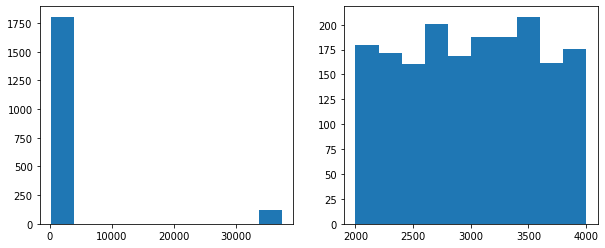

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(DF['revenue'].loc[(DF['testgroup']=='a') & (DF['revenue']>0)])
axs[1].hist(DF['revenue'].loc[(DF['testgroup']=='b') & (DF['revenue']>0)])

Глядя на гистограммы мы можем сказать что наборы данных не имеют формы "колокола" следовательно - не имеют нормального распределения

In [28]:
print(stats.shapiro(DF['revenue'].loc[(DF['testgroup']=='a') & (DF['revenue']>0)]))
print(stats.shapiro(DF['revenue'].loc[(DF['testgroup']=='b') & (DF['revenue']>0)]))

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)
ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)


Т.к. pvalue теста Шапиро-Уилка << 0.05 - следовательно мы имеем дело с ненормальным распределением.

#### Cравним выборки методом bootstrap.
У нас есть категориальная переменная (группа "А" или "В"), у нас также имеется количественная переменная - сумма оплаты.\
Проанализируем, как категориальный фактор (группа) влияет на метрику ARPPU (средний доход с одного платящего пользователя) и ARPU (Средний доход с одного пользователя).\
Так как наши распределения выборок не являются нормальными, можно использовать бутстреп анализ, так как он позволяет получить оценки и доверительные интервалы для статистических параметров (например, средних) без предположений о нормальности распределении данных. В нашем случае, это может быть использовано для оценки неопределенности в связи с метриками ARPPU и ARPU.

In [29]:
# Сравним с помощью данной функции средние значения между группами:
def get_bootstrap_mean( #
    data_column_1,
    data_column_2,
    boot_it=1000, # количество бутстреп-подвыборок для создания (1000 выборок)
    statistic=np.mean, # статистика, которую мы хотим оценить (np.mean - среднее значение)
    bootstrap_conf_level=0.95 # уровень значимости 
):
    boot_data = []
    for i in range(boot_it): # генерация бутстреп-подвыборок
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2)) # список, в который записывается разница между 
        # значениями статистики для бутстреп-подвыборок групп A и B
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Построение графика
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

#### Проведем проверку гипотезы:
- H0 (нулевая гипотеза): Связь между метрикой ARPU и групповой принадлежностью отсутствует;
- H1 (альтернативная гипотеза): Взаимосвязь между группой и ARPU, все-таки, имеется.

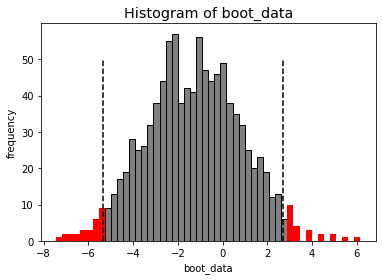

p_value: 0.5411935054801067
quants:               0
0.025 -5.351810
0.975  2.696421


In [30]:
# Подаем соответствующие данные на функцию и выводим полученный результат
booted_data_mean_arpu = get_bootstrap_mean(DF['revenue'].loc[(DF['testgroup']=='a')],
                                      DF['revenue'].loc[(DF['testgroup']=='b')])

print("p_value:", booted_data_mean_arpu["p_value"])
print("quants:", booted_data_mean_arpu["quants"])

#### Результат сравнения ARPU групп не показал статистического различия показателей (p-value = ~0.5 >> 0.05).
#### Поэтому мы не отклоняем нулевую гипотезу и можем сделать вывод, что акционные наборы не повлияли на ARPU. 

### Анализ ARPPU

In [31]:
# Оценим и метрику ARPPU.
Indicators[['testgroup', 'ARPPU']]

,testgroup,ARPPU
0,a,2663.998444
1,b,3003.658172


#### Проведем проверку гипотезы:
- H0 (нулевая гипотеза): Связь между метрикой ARPPU и групповой принадлежностью отсутствует;
- H1 (альтернативная гипотеза): Взаимосвязь между группой и ARPPU присутствует.

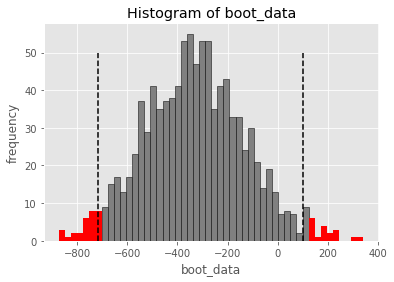

p_value: 0.10164622925935539
quants:                 0
0.025 -716.635283
0.975  102.315936


In [32]:
booted_data_mean_arppu = get_bootstrap_mean(DF['revenue'].loc[(DF['testgroup']=='a') & (DF['revenue']>0)],
                                      DF['revenue'].loc[(DF['testgroup']=='b') & (DF['revenue']>0)])

print("p_value:", booted_data_mean_arppu["p_value"])
print("quants:", booted_data_mean_arppu["quants"])

#### Бутстреп-анализ ARPPU также показал отсутствие статистически значимого отличия показателей.
#### Поэтому мы также не отклоняем нулевую гипотезу и делаем вывод, что акционные наборы не повлияли на ARPPU. 

### Предположим что выбросы в группе А обусловлены попаданием клиентов премиум класса в контрольную группу но в тоже время они не попали в тестовую группу, следовательно при разделени пользователей для А/В тестирование произошла ошибка. Либо выбросы могу быть обусловлены ошибкой логирования системы оплат. Так что мы можем отсеч эти 123 пользователя и провести анализ без них.

### Анализ ARPU с отсеченными выбросами

#### Проведем проверку гипотезы:
- H0 (нулевая гипотеза): Связь между метрикой ARPU и групповой принадлежностью отсутствует;
- H1 (альтернативная гипотеза): Взаимосвязь между группой и ARPU, все-таки, имеется.

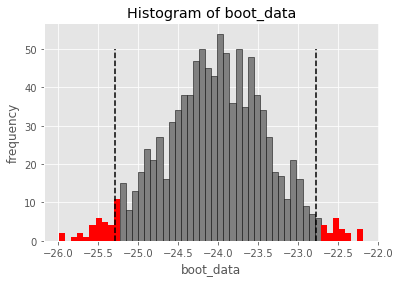

p_value: 2.3128432199247127e-304
quants:                0
0.025 -25.292764
0.975 -22.774082


In [33]:
# Подаем соответствующие данные на функцию и выводим полученный результат
booted_data_mean_arpu = get_bootstrap_mean(DF['revenue'].loc[(DF['testgroup']=='a') & (DF['revenue']<5000)],
                                      DF['revenue'].loc[(DF['testgroup']=='b')])

print("p_value:", booted_data_mean_arpu["p_value"])
print("quants:", booted_data_mean_arpu["quants"])

#### Результат сравнения ARPU групп показал статистически значимое различие показателей (p-value << 0.05).
#### Поэтому мы отклоняем нулевую гипотезу и можем сделать вывод, что акционные наборы повлияли на ARPU.

### Анализ ARPPU с отсеченными выбросами

#### Проведем проверку гипотезы:
- H0 (нулевая гипотеза): Связь между метрикой ARPPU и групповой принадлежностью отсутствует;
- H1 (альтернативная гипотеза): Взаимосвязь между группой и ARPPU, все-таки, имеется.

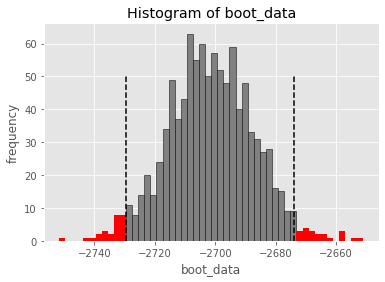

p_value: 0.0
quants:                  0
0.025 -2729.685125
0.975 -2674.147936


In [34]:
booted_data_mean_arpu = get_bootstrap_mean(DF['revenue'].loc[(DF['testgroup']=='a') & (DF['revenue']>0) & (DF['revenue']<5000)],
                                      DF['revenue'].loc[(DF['testgroup']=='b') & (DF['revenue']>0)])

print("p_value:", booted_data_mean_arpu["p_value"])
print("quants:", booted_data_mean_arpu["quants"])

#### Результат сравнения ARPPU групп показал статистически значимое различия показателей (p-value << 0.05).
#### Поэтому мы отклоняем нулевую гипотезу и можем сделать вывод, что акционные наборы повлияли на ARPPU.

## Анализ ARPU и ARPPU с помошью непараметрического критерия Манна-Уитни

Т.к. распределение данных не является нормальным и имеются выбросы можем применить непараметрический критерий для проверки истинных медианных значений выборок

### ARPU

#### Проведем проверку гипотезы:
- H0 (нулевая гипотеза): истинная медиана ARPU одинакова для обоих групп;
- H1 (альтернативная гипотеза): истинная медиана ARPU для обоих групп отличается.

In [35]:
# Проведем непараметрический тест Манна-Уитни
from scipy.stats import mannwhitneyu

statistic, pvalue = mannwhitneyu(DF['revenue'].loc[(DF['testgroup']=='a')],
                                DF['revenue'].loc[(DF['testgroup']=='b')],
                                 alternative='two-sided')

print(f'Mann-Whitney U test: U = {int(statistic)}, p = {pvalue}')

Mann-Whitney U test: U = 20491259376, p = 0.06269701316074398


#### Результат сравнения ARPU групп не показал статистически значимого различия показателей (p-value > 0.05).
#### Поэтому мы не отклоняем нулевую гипотезу и можем сделать вывод, что акционные наборы не повлияли на ARPU.

### ARPPU

#### Проведем проверку гипотезы:
- H0 (нулевая гипотеза): истинная медиана ARPPU одинакова для обоих групп;
- H1 (альтернативная гипотеза): истинная медиана ARPPU для обоих групп отличается.

In [36]:
statistic, pvalue = mannwhitneyu(DF['revenue'].loc[(DF['testgroup']=='a') & (DF['revenue']>0)],
                                DF['revenue'].loc[(DF['testgroup']=='b') & (DF['revenue']>0)],
                                 alternative='two-sided')

print(f'Mann-Whitney U test: U = {int(statistic)}, p = {pvalue}')

Mann-Whitney U test: U = 222015, p = 0.0


#### Результат сравнения ARPPU групп показал статистически значимое различие показателей (p-value << 0.05).
#### Поэтому мы отклоняем нулевую гипотезу и можем сделать вывод, что акционные наборы повлияли на ARPPU.

## ВЫВОДЫ

- Медианные чеки двух групп существенно отличаются;
- Распределение покупок в группе B - равномерно, в пределах 2000-4000 рублей. В группе A - присутствуют 123 человека из 202103, кто приобретал дорогие покупки;
- Стоит обратить внимание на тех 123 человек из группы А, кто совершил дорогостоящие покупки. Они являются частью в 0.06% от числа пользователей группы A, однако вносят наибольшую часть выручки.
- Результаты непараметрического теста Манна-Уитни(менее чувствительного к выбросам) показывают различия в ARPPU, но не в ARPU. Это может указывать на то, что изменения в акционных предложениях влияют на доход только у платящих пользователей и не оказывают значительного влияния на общий доход от всех пользователей.
- Т.к. в данных были обнаружены 123 аномальных значений суммы покупок в контрольной группе. Для формулировки  выводов нужно дополнительно запрашивать информацию о природе появления выбросов в контрольной группе.
- Выбросы влияют на результаты бутстрап анализа ARPU и ARPPU, и на результаты теста Хи-квадрат по конверсии. А следовательно на выводы.
#### Можно сделать следующие заключение по результатам исследования данных:

`1. Если мы не отсекаем выбросы и акционные предложения с такими ценами действительно существуют. По результатам бутстрап анализа - ARPU и ARPPU статзначимо не отличаются в контрольной и тестовой группах. По результатам теста Хи-квадрат - конверсия статзначимо ниже в тестовой группе чем в контрольной. И мы выбираем набор акционных предложений группы А.`

`2. Если же выбросы попали в выборку ошибочно и акционных предложений с такими ценами не существует. По результатам бутстрап анализа с отсеченными выбросами - ARPU и ARPPU статзначимо выросло в тестовой группе. По результатам теста Хи-квадрат - конверсия с отсеченными выбросами статзначимо не изменилась. Мы выбираем набор акционных предложений группы В.`

### Сделать окончательные выводы не представляется возможным без информации о природе возникновения аномальных значений в контрольной группе, т.к. выбросы влияют на результаты тестов.